# SIS on infinite random $k$-regular graph

In [41]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [58]:
T = 30         # final time
k = 4          # degree
γ = 4e-1       # prob. of zero patient
ΔT = 0.2       # discretization
λ = 0.1        # rate of transmission
ρ = 0.2        # rate of recovery

0.2

In [59]:
svd_trunc = TruncBond(6)
maxiter = 200
tol = 1e-5
wᵢ = fill(SISFactor(λ, ρ), floor(Int, T/ΔT))
ϕᵢ = [ t == 0 ? [1-γ, γ] : ones(2) for t in 0:floor(Int, T/ΔT)]
A, iters, Δs = iterate_bp_infinite_graph(floor(Int, T/ΔT), k, wᵢ, ϕᵢ; svd_trunc, maxiter, tol);

Iterating BP on infinite graph   9%|█▉                   |  ETA: 0:04:15
  iter:  18/200
  Δ:     1.0556535e-5/1.0e-5

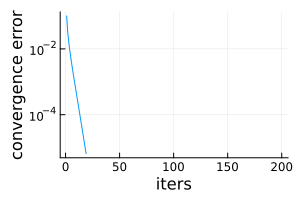

In [60]:
plot(Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="")

In [61]:
# compute magnetization, correlation and covariance
b, m, c = observables_infinite_graph(A, k, wᵢ, ϕᵢ; svd_trunc, showprogress=true);

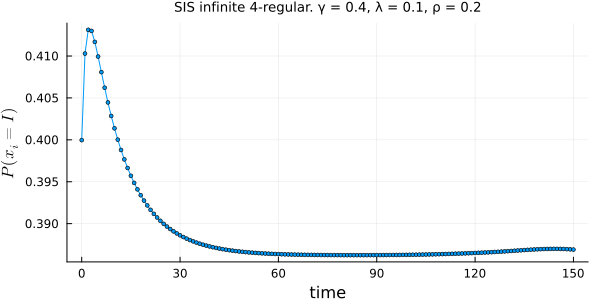

In [62]:
marg = [bᵗ[INFECTED] for bᵗ in b]
pl_marg = plot(0:floor(Int, T/ΔT), marg, m=:o, xlabel="time", ylabel="\$P(x_i=I)\$", label="",
    size=(600,300), xticks=0:30:floor(Int, T/ΔT), ms=2,titlefontsize=9,
    title = "SIS infinite $k-regular. γ = $γ, λ = $λ, ρ = $ρ")

In [63]:
using ColorSchemes
function plot_autocovs!(pl, c; skip_even=true, us = 10:20:size(c,1)-1,
        cg = cgrad(:matter, length(us), categorical=true), kw...)
    step = skip_even ? 2 : 1
    ylabel = "\$\\langle x_i^t x_i^{t+\\Delta t}\\rangle-" * 
        "\\langle x_i^t\\rangle\\langle x_i^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    plot!(pl ;xlabel, ylabel, legend=:outertopright, 
        title="SIS infinite $k-regular. γ = $γ, λ = $λ, ρ = $ρ. Matrix size $(svd_trunc.mprime)")
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  
plot_autocovs(args...; kwargs...) = plot_autocovs!(plot(), args...; kwargs...)

plot_autocovs (generic function with 1 method)

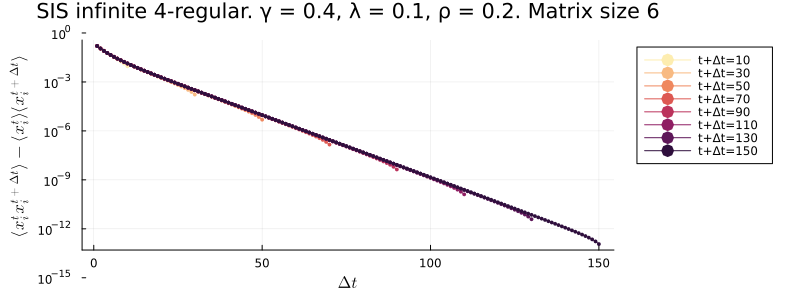

In [64]:
skip_even = false
cc = map(x -> x > 0 ? x : 1e-17, c);
pl_autocov = plot_autocovs(cc; skip_even, yaxis=:log10, yticks=7, 
    size=(800,300), margin=5Plots.mm, ms=2)

## Varying the size of matrices

In [65]:
sizes = [4, 10, 20]
magnetizations = [zeros(0) for _ in sizes]
covariances = [zeros(0, 0) for _ in sizes];

In [66]:
for s in eachindex(sizes)
    println("### Size $s of $(length(sizes))")
    cg = cgrad(:matter, length(sizes), categorical=true)
    sz = sizes[s]
    svd_trunc = TruncBond(sz)
    A, iters, Δs = iterate_bp_infinite_graph(floor(Int, T/ΔT), k, wᵢ, ϕᵢ; svd_trunc, maxiter, tol)
    iters == maxiter && error("BP did not converge for matrix size $sz")
    b, magnetizations[s], covariances[s] = observables_infinite_graph(A, k, wᵢ, ϕᵢ; svd_trunc, 
        showprogress=true)
end

Iterating BP on infinite graph   9%|█▉                   |  ETA: 0:12:32
  iter:  18/200
  Δ:     1.0713397e-5/1.0e-5

In [69]:
pl_mag = plot(); pl_cov = plot()
cg = cgrad(:matter, length(sizes), categorical=true)

for s in eachindex(sizes)
    sz = sizes[s]
    plot!(pl_mag, 0:floor(Int, T/ΔT), magnetizations[s], m=:o, xlabel="time", ylabel="\$P(x_i=I)\$",
        size=(600,300), xticks=0:20:floor(Int, T/ΔT), ms=2, c = cg[s], msc=cg[s],
        label = "Matrix size $sz", legend=:topleft)
    us = 10:20:floor(Int, T/ΔT)
    plot_autocovs!(pl_cov, covariances[s]; us, cg = cgrad(fill(cg[s], length(us))), yaxis=:log10,
        yticks = 4)
    plot!(pl_cov, title="")
end

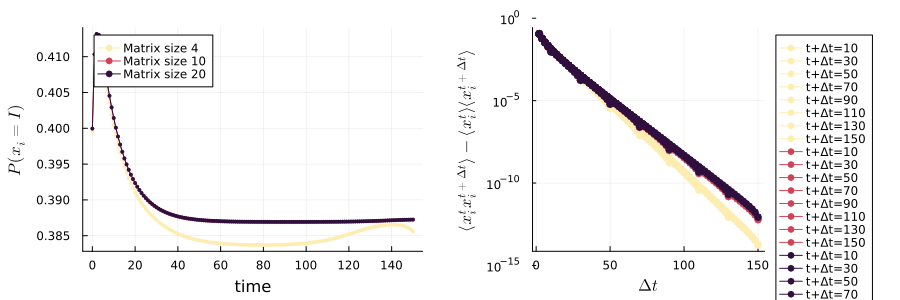

In [70]:
plot(pl_mag, pl_cov, size=(900,300), margin=5Plots.mm)